In [1]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv, NNConv, global_mean_pool, TopKPooling
from torch_geometric.nn.glob import GlobalAttention
from torch_geometric.data import Data,DataLoader
# from torch.utils.data import DataLoader, TensorDataset
# from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from torch_geometric.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip
from torch_geometric.utils import add_self_loops

from scipy import sparse

# load pickle module
import pickle
import networkx as nx
import torch.nn as nn

from tqdm import tqdm 

In [2]:
R0 = 2.5
rs = np.array([20, 10, 2.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.025, 5.   ,  2.5  , 13.333,  3.333,  1.333,  0.667,  0.286,  0.133,
        0.067,  0.033])

In [3]:
rs.sort()

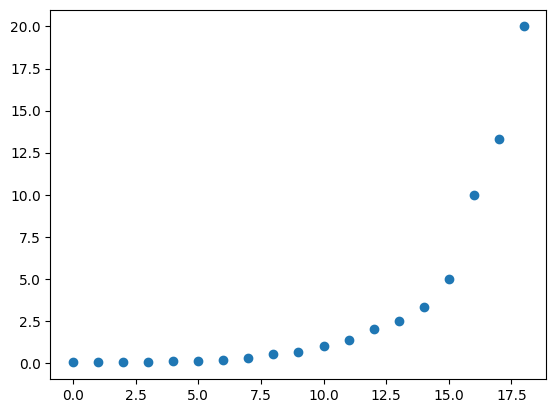

In [5]:
plt.scatter(range(19),rs)

In [6]:
WN = np.loadtxt('../W_avg.csv') ### numpy arrary
WN2 = np.dot(WN, WN)
# prob = WN[:,1858]
prob = WN2[:,1858]
prob_2d = prob.reshape(-1,1)

In [7]:
g_s = nx.from_numpy_array(WN)
edges = np.array(g_s.edges()).transpose()
edge_index = torch.tensor(edges,dtype = torch.int64)
# edge_weight = torch.tensor(WN[edge_index[0], edge_index[1]], dtype=torch.float)
edge_weights = []
for (u, v) in g_s.edges():
    edge_weights.append([g_s[u][v]['weight']])
edge_weights = torch.tensor(edge_weights, dtype=torch.float32)

In [8]:
def load_gzipped_numpy(filename):
    try:
        with gzip.open(filename, 'rb') as f:
            return np.load(f, allow_pickle=True)
    except FileNotFoundError:
        return [0]

In [13]:
export_dir = '/Users/qingyao/Documents/branching_data/simulation/python_cutoff_addno/'
#### data preparation
dataset = []

for r_idx in range(19):
    r = rs[r_idx]
    sub_export_dir = export_dir+'branching_R0-{}_r-{}/'.format(np.round(R0,2),np.round(r,3))
    r_c = r_class[r]
    print(r, r_c)
    # Create a list to hold our Data objects
    for g_idx in range(300):
        export_names = sub_export_dir+'NewInf_R0-{}_r-{}_{}.npy.gz'.format(np.round(R0,2),np.round(r,3),(g_idx+1))
        g_i = load_gzipped_numpy(export_names)
#         g_i_new = np.hstack((g_i[:,10:], prob_2d))
        g_i_new = g_i[:,10:] * prob_2d
        
        matrix = torch.from_numpy(g_i_new)
        
#         y = torch.log(torch.tensor([[r]], dtype=torch.float))
        y = torch.tensor([[r]], dtype=torch.float)
        # Create a Data object for each graph
        data = Data(x=matrix, edge_index=edge_index, edge_attr=edge_weights,y=y)
        data.x = data.x.float()
#         data.y = data.y.long()
        # Add the Data object to our list
        dataset.append(data)

0.025 3
0.033 3
0.05 3
0.067 3
0.1 2
0.133 2
0.2 2
0.286 2
0.5 1
0.667 1
1.0 1
1.333 1
2.0 1
2.5 1
3.333 1
5.0 0
10.0 0
13.333 0
20.0 0


In [14]:
len(dataset)

5700

In [15]:
from torch.utils.data import random_split
train_data, test_data = random_split(dataset, [int(5700*0.8), int(5700*0.2)])

In [82]:
def weighted_mse_loss(input, target, weight):
    # Calculate MSE loss for each sample
    individual_losses = F.mse_loss(input, target, reduction='none')
    
    # Apply weights
    weighted_losses = individual_losses * weight
    
    # Average over all samples
    loss = weighted_losses.mean()
    return loss

In [86]:
def calculate_weights(targets, threshold):
    # Assign a higher weight to targets above a certain threshold
    weights = torch.ones_like(targets)
    weights[targets > threshold] = 2  # e.g., 2, 3, 5, etc.
    return weights

In [16]:
class GCN(torch.nn.Module): ### the simpliest model that GNN and it is classical, used as baseline
    def __init__(self, num_node_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 128)     
        self.conv2 = GCNConv(128, 64) 
        self.conv3 = GCNConv(64, 16) 
        self.conv4 = GCNConv(16, 8) 
        self.fc = torch.nn.Linear(8, 1)


    """
        hyperparameters:
        - number of hidden layers
        - number of hidden channels
        - dropout rate (now it's zero)
        - learning rate <- most important to tune
        - weight decay
        - etc etc.
    """

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
        edge_index, edge_weight = add_self_loops(edge_index, edge_attr=edge_weight, num_nodes=x.size(0))

        x = self.conv1(x, edge_index, edge_weight)
        x = F.leaky_relu(x)
#         x = F.elu(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = F.leaky_relu(x)
#         x = F.elu(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = F.leaky_relu(x)
#         x = F.elu(x)
        
        x = self.conv4(x, edge_index, edge_weight)
        x = F.leaky_relu(x)
#         x = F.elu(x)

        x = global_mean_pool(x, batch)
        x = self.fc(x)

        return x

# Now we can create a DataLoader
myloader = DataLoader(train_data, batch_size=128, shuffle=True)
# Create a model and an optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_node_features=50).to(device) ### only look at the last 30 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

def train(model, optimizer, loader):
    model.train()
    loss_all = 0
    correct = 0
    y_true = []
    total = 0
    results = []
    for data in myloader:
        data = data.to(device)
        optimizer.zero_grad() 
        output = model(data) 
        label = data.y.to(device)
        y_true.append(label)
#         loss = F.cross_entropy(output, label)
        loss = F.mse_loss(output, label) 
        loss.backward() 
        loss_all += data.num_graphs * loss.item()
        
        optimizer.step() 
        results.append(output)
    
    return loss_all / len(myloader.dataset), results, y_true



counter = 0
count_epochs = 0
best = float("inf")
epochs = 100
patience = 15
loss_ep= []
 
for epoch in (pbar := tqdm(range(1, epochs + 1))):
    loss, myres, reals = train(model, optimizer, myloader)
    loss_ep.append(loss)
#     ac_ep.append(ac)
    print('Epoch: {:03d}, Loss: {:.5f}'.format(epoch, loss))
    if loss < best:
        best = loss
        counter = 0
    else:
        counter += 1
        count_epochs += 1
        
    if counter > patience:
        break
        # print(f"Epoch: {​​​​​​epoch:03d}​​​​​​, Loss: {​​​​​​loss:.4f}​​​​​​")
#     scheduler.step()
    pbar.set_description(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")
print("\n", "Stopped early at epoch: ", count_epochs)


/Users/qingyao/anaconda3/envs/gnn/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Epoch: 001, Loss: 29.7212:   1%|              | 1/150 [00:36<1:30:29, 36.44s/it]

Epoch: 001, Loss: 29.72117


Epoch: 002, Loss: 28.2056:   1%|▏             | 2/150 [01:12<1:28:51, 36.02s/it]

Epoch: 002, Loss: 28.20556


Epoch: 003, Loss: 28.1987:   2%|▎             | 3/150 [01:48<1:28:09, 35.98s/it]

Epoch: 003, Loss: 28.19875


Epoch: 004, Loss: 25.0120:   3%|▎             | 4/150 [02:24<1:27:35, 36.00s/it]

Epoch: 004, Loss: 25.01202


Epoch: 005, Loss: 22.3049:   3%|▍             | 5/150 [03:00<1:27:01, 36.01s/it]

Epoch: 005, Loss: 22.30491


Epoch: 006, Loss: 23.5138:   4%|▌             | 6/150 [03:36<1:26:44, 36.14s/it]

Epoch: 006, Loss: 23.51381


Epoch: 007, Loss: 22.7783:   5%|▋             | 7/150 [04:12<1:26:19, 36.22s/it]

Epoch: 007, Loss: 22.77834


Epoch: 008, Loss: 20.3408:   5%|▋             | 8/150 [04:49<1:25:48, 36.26s/it]

Epoch: 008, Loss: 20.34081


Epoch: 009, Loss: 18.9422:   6%|▊             | 9/150 [05:25<1:25:23, 36.34s/it]

Epoch: 009, Loss: 18.94221


Epoch: 010, Loss: 20.2794:   7%|▊            | 10/150 [06:02<1:24:57, 36.41s/it]

Epoch: 010, Loss: 20.27943


Epoch: 011, Loss: 20.0851:   7%|▉            | 11/150 [06:40<1:25:24, 36.87s/it]

Epoch: 011, Loss: 20.08513


Epoch: 012, Loss: 22.8779:   8%|█            | 12/150 [07:26<1:31:11, 39.65s/it]

Epoch: 012, Loss: 22.87786


Epoch: 013, Loss: 21.5656:   9%|█▏           | 13/150 [08:10<1:33:52, 41.11s/it]

Epoch: 013, Loss: 21.56556


Epoch: 014, Loss: 18.5226:   9%|█▏           | 14/150 [08:56<1:36:19, 42.49s/it]

Epoch: 014, Loss: 18.52257


Epoch: 015, Loss: 17.5737:  10%|█▎           | 15/150 [09:42<1:38:04, 43.59s/it]

Epoch: 015, Loss: 17.57368


Epoch: 016, Loss: 17.1207:  11%|█▍           | 16/150 [10:28<1:38:40, 44.18s/it]

Epoch: 016, Loss: 17.12072


Epoch: 017, Loss: 16.7569:  11%|█▍           | 17/150 [11:14<1:39:21, 44.83s/it]

Epoch: 017, Loss: 16.75695


Epoch: 018, Loss: 18.4448:  12%|█▌           | 18/150 [12:00<1:39:13, 45.11s/it]

Epoch: 018, Loss: 18.44484


Epoch: 019, Loss: 17.8906:  13%|█▋           | 19/150 [12:46<1:39:05, 45.39s/it]

Epoch: 019, Loss: 17.89061


Epoch: 020, Loss: 16.9089:  13%|█▋           | 20/150 [13:31<1:38:09, 45.30s/it]

Epoch: 020, Loss: 16.90894


Epoch: 021, Loss: 17.1987:  14%|█▊           | 21/150 [14:18<1:38:19, 45.73s/it]

Epoch: 021, Loss: 17.19869


Epoch: 022, Loss: 15.2648:  15%|█▉           | 22/150 [15:04<1:37:52, 45.88s/it]

Epoch: 022, Loss: 15.26484


Epoch: 023, Loss: 15.8484:  15%|█▉           | 23/150 [15:51<1:37:40, 46.14s/it]

Epoch: 023, Loss: 15.84838


Epoch: 024, Loss: 16.1360:  16%|██           | 24/150 [16:37<1:37:18, 46.34s/it]

Epoch: 024, Loss: 16.13601


Epoch: 025, Loss: 15.6759:  17%|██▏          | 25/150 [17:24<1:36:52, 46.50s/it]

Epoch: 025, Loss: 15.67592


Epoch: 026, Loss: 16.7394:  17%|██▎          | 26/150 [18:12<1:36:56, 46.91s/it]

Epoch: 026, Loss: 16.73936


Epoch: 027, Loss: 16.3050:  18%|██▎          | 27/150 [18:58<1:35:42, 46.68s/it]

Epoch: 027, Loss: 16.30501


Epoch: 028, Loss: 15.3183:  19%|██▍          | 28/150 [19:45<1:34:59, 46.72s/it]

Epoch: 028, Loss: 15.31827


Epoch: 029, Loss: 16.4756:  19%|██▌          | 29/150 [20:31<1:33:58, 46.60s/it]

Epoch: 029, Loss: 16.47559


Epoch: 030, Loss: 17.4584:  20%|██▌          | 30/150 [21:19<1:33:31, 46.76s/it]

Epoch: 030, Loss: 17.45844


Epoch: 031, Loss: 17.7935:  21%|██▋          | 31/150 [22:04<1:32:06, 46.44s/it]

Epoch: 031, Loss: 17.79352


Epoch: 032, Loss: 19.7463:  21%|██▊          | 32/150 [22:50<1:31:11, 46.37s/it]

Epoch: 032, Loss: 19.74632


Epoch: 033, Loss: 15.6471:  22%|██▊          | 33/150 [23:36<1:30:12, 46.26s/it]

Epoch: 033, Loss: 15.64709


Epoch: 034, Loss: 15.3864:  23%|██▉          | 34/150 [24:23<1:29:30, 46.30s/it]

Epoch: 034, Loss: 15.38639


Epoch: 035, Loss: 17.7010:  23%|███          | 35/150 [25:09<1:28:36, 46.23s/it]

Epoch: 035, Loss: 17.70101


Epoch: 036, Loss: 19.1944:  24%|███          | 36/150 [25:56<1:28:10, 46.41s/it]

Epoch: 036, Loss: 19.19445


Epoch: 037, Loss: 17.7940:  25%|███▏         | 37/150 [26:43<1:27:38, 46.53s/it]

Epoch: 037, Loss: 17.79402


Epoch: 038, Loss: 14.4215:  25%|███▎         | 38/150 [27:30<1:27:35, 46.93s/it]

Epoch: 038, Loss: 14.42148


Epoch: 039, Loss: 14.5587:  26%|███▍         | 39/150 [28:26<1:31:39, 49.55s/it]

Epoch: 039, Loss: 14.55869


Epoch: 040, Loss: 17.9688:  27%|███▍         | 40/150 [29:25<1:36:14, 52.50s/it]

Epoch: 040, Loss: 17.96882


Epoch: 041, Loss: 15.0922:  27%|███▌         | 41/150 [30:19<1:36:10, 52.94s/it]

Epoch: 041, Loss: 15.09216


Epoch: 042, Loss: 15.7066:  28%|███▋         | 42/150 [31:06<1:31:44, 50.96s/it]

Epoch: 042, Loss: 15.70658


Epoch: 043, Loss: 16.6260:  29%|███▋         | 43/150 [31:53<1:28:43, 49.75s/it]

Epoch: 043, Loss: 16.62595


Epoch: 044, Loss: 15.9527:  29%|███▊         | 44/150 [32:40<1:26:20, 48.88s/it]

Epoch: 044, Loss: 15.95273


Epoch: 045, Loss: 15.7277:  30%|███▉         | 45/150 [33:25<1:23:54, 47.95s/it]

Epoch: 045, Loss: 15.72772


Epoch: 046, Loss: 16.3127:  31%|███▉         | 46/150 [34:11<1:21:50, 47.22s/it]

Epoch: 046, Loss: 16.31268


Epoch: 047, Loss: 16.1508:  31%|████         | 47/150 [34:57<1:20:21, 46.82s/it]

Epoch: 047, Loss: 16.15081


Epoch: 048, Loss: 15.4014:  32%|████▏        | 48/150 [35:43<1:19:05, 46.52s/it]

Epoch: 048, Loss: 15.40137


Epoch: 049, Loss: 16.5546:  33%|████▏        | 49/150 [36:28<1:17:57, 46.31s/it]

Epoch: 049, Loss: 16.55461


Epoch: 050, Loss: 14.9542:  33%|████▎        | 50/150 [37:14<1:16:53, 46.13s/it]

Epoch: 050, Loss: 14.95423


Epoch: 051, Loss: 15.3080:  34%|████▍        | 51/150 [38:00<1:16:01, 46.07s/it]

Epoch: 051, Loss: 15.30803


Epoch: 052, Loss: 15.0806:  35%|████▌        | 52/150 [38:46<1:15:22, 46.15s/it]

Epoch: 052, Loss: 15.08059


Epoch: 053, Loss: 15.4249:  35%|████▌        | 53/150 [39:32<1:14:29, 46.08s/it]

Epoch: 053, Loss: 15.42494


Epoch: 053, Loss: 15.4249:  35%|████▌        | 53/150 [40:19<1:13:47, 45.65s/it]

Epoch: 054, Loss: 14.80411

 Stopped early at epoch:  41


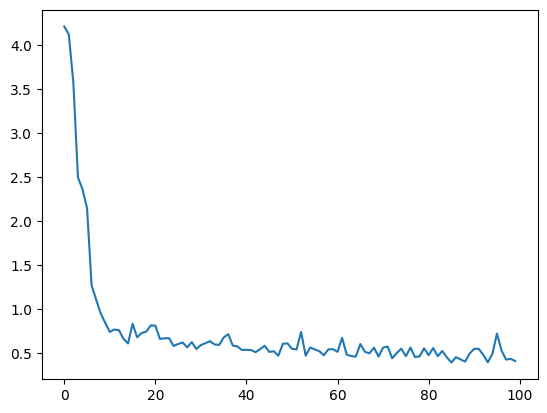

In [80]:
plt.plot(loss_ep)

In [17]:
def bootstrap_median_confidence_interval(data, ci=95, n_bootstraps=1000):
    bootstrapped_medians = []
    n = len(data)

    for _ in range(n_bootstraps):
        sample = np.random.choice(data, size=n, replace=True)
        bootstrapped_medians.append(np.median(sample))

    lower_bound = np.percentile(bootstrapped_medians, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrapped_medians, 100 - (100 - ci) / 2)
    medians = np.percentile(bootstrapped_medians, 50)

    return medians, lower_bound, upper_bound

In [18]:
training_y = []
training_true = []
for t_s in range(17):
    training_y.extend(list(myres[t_s].detach().ravel().numpy()))
    training_true.extend(list(reals[t_s].detach().ravel().numpy()))

In [22]:
training = {}
for p, t in zip(training_y, training_true):
#     real_r = np.round(np.exp(t),3)
    real_r = np.round(t,3)
    if real_r in training.keys():
        training[real_r].append(p)
    else:
        training[real_r] = [p]

In [33]:
type(list(training.keys())[10])

numpy.float32

In [34]:
Bootstrap_ci = []
Bootstrap_mean = []
for r_idx in range(19):
    r = rs[r_idx]
    r = np.float32(r)
    print(r)
#     data = np.exp(training[r])
    data = training[r]
    k = np.log(r)
#     print(len(data))
#     Bootstrap_mean.append(np.median(data))
    sample_median, l_b, u_b = bootstrap_median_confidence_interval(data,95)
    Bootstrap_ci.append([l_b, u_b])
    Bootstrap_mean.append(sample_median)
#     print("T-Distribution 90% Confidence Interval:", t_distribution_confidence_interval(data))
#     print("Bootstrap 95% Confidence Interval:",l_b, u_b)

0.025
0.033
0.05
0.067
0.1
0.133
0.2
0.286
0.5
0.667
1.0
1.333
2.0
2.5
3.333
5.0
10.0
13.333
20.0


In [35]:
CI = np.array(Bootstrap_ci)

In [39]:
Bootstrap_mean

[-0.28782185912132263,
 -0.3580248951911926,
 -0.3064799904823303,
 -0.07632628083229065,
 -0.20494040846824646,
 0.0274810791015625,
 -0.018001526594161987,
 0.5470784306526184,
 1.575674057006836,
 1.8737534284591675,
 3.6547482013702393,
 3.739645481109619,
 5.1522932052612305,
 5.745384693145752,
 6.134951591491699,
 6.8976874351501465,
 7.734098434448242,
 7.829336166381836,
 7.864086151123047]

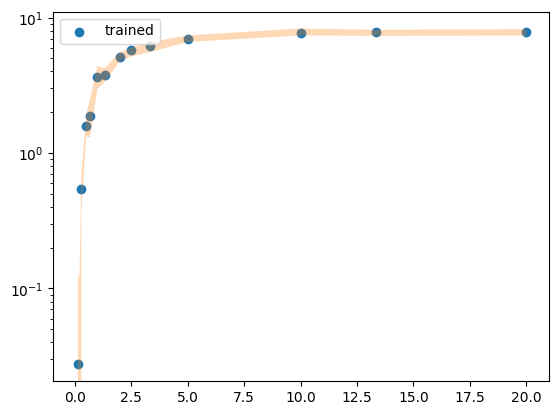

In [41]:
# plt.scatter(rs,rs,label='real')
plt.scatter(rs,np.array(Bootstrap_mean),label='trained')
plt.fill_between(rs,CI[:,1],CI[:,0],alpha=0.3)
plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.savefig('regression.png')

In [16]:
def test():
    model.eval()
    predictions = []
    total_loss = 0
    true_values = []
    with torch.no_grad():
        for data in testloader:
            data = data.to(device)
            output = model(data)
            loss = F.mse_loss(output, data.y)
            total_loss += loss.item() * data.num_graphs
            predictions.append(output.cpu())
            true_values.append(data.y.cpu())
    return torch.cat(predictions, dim=0), torch.cat(true_values, dim=0),total_loss / len(testloader.dataset)

In [17]:
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [18]:
predictions, y_true, test_mse  = test()
print(f"Test MSE: {test_mse:.4f}")
# print(predictions)

Test MSE: 0.3433


In [19]:
results = {}
for p, t in zip(predictions.ravel().numpy(), y_true.ravel().numpy()):
    real_r = np.round(np.exp(t),3)
    if real_r in results.keys():
        results[real_r].append(p)
    else:
        results[real_r] = [p]

In [58]:
import pickle

# Assuming 'results' is your dictionary
with open('gnn_regression_add.pkl', 'wb') as file:
    pickle.dump(results, file)

In [20]:
import scipy.stats as stats


for r_idx in range(19):
    r = rs[r_idx]
    r = np.float32(r)
    data = results[r]
    k = np.log(r)
    print(k)
    print("T-Distribution 99% Confidence Interval:", t_distribution_confidence_interval(data,99))
#     print("Bootstrap 95% Confidence Interval:", bootstrap_confidence_interval(data))

-3.6888795
T-Distribution 99% Confidence Interval: (-3.3979023206986594, -3.0001284372053934)
-3.4112477
T-Distribution 99% Confidence Interval: (-3.213641105089242, -2.8353229185008457)
-2.9957323
T-Distribution 99% Confidence Interval: (-2.9492508261084796, -2.5963467271446943)
-2.7030625
T-Distribution 99% Confidence Interval: (-2.78764652016801, -2.4383962273295485)
-2.3025851
T-Distribution 99% Confidence Interval: (-2.466643518111105, -2.184056574204569)
-2.0174062
T-Distribution 99% Confidence Interval: (-2.374218206765222, -2.0971834846715454)
-1.609438
T-Distribution 99% Confidence Interval: (-2.0369302732438426, -1.7949569719343799)
-1.2517635
T-Distribution 99% Confidence Interval: (-1.7068355584868384, -1.4136657213440942)
-0.6931472
T-Distribution 99% Confidence Interval: (-0.9402775519098976, -0.672144795158889)
-0.40496525
T-Distribution 99% Confidence Interval: (-0.6215256227667165, -0.34248568876435037)
0.0
T-Distribution 99% Confidence Interval: (-0.1562435190365869, 

In [11]:
r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3, 
           5.0:0 ,  2.5:1  , 13.333:0,  3.333:1,  1.333:1,  0.667:1,  0.286:2,  0.133:2,
        0.067:3,  0.033:3}

In [12]:
r_class.keys()

dict_keys([20, 10, 2.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.025, 5.0, 2.5, 13.333, 3.333, 1.333, 0.667, 0.286, 0.133, 0.067, 0.033])

52
60
55
59
62
54
59
53
59
59
61
72
69
60
55
67
58
56
70


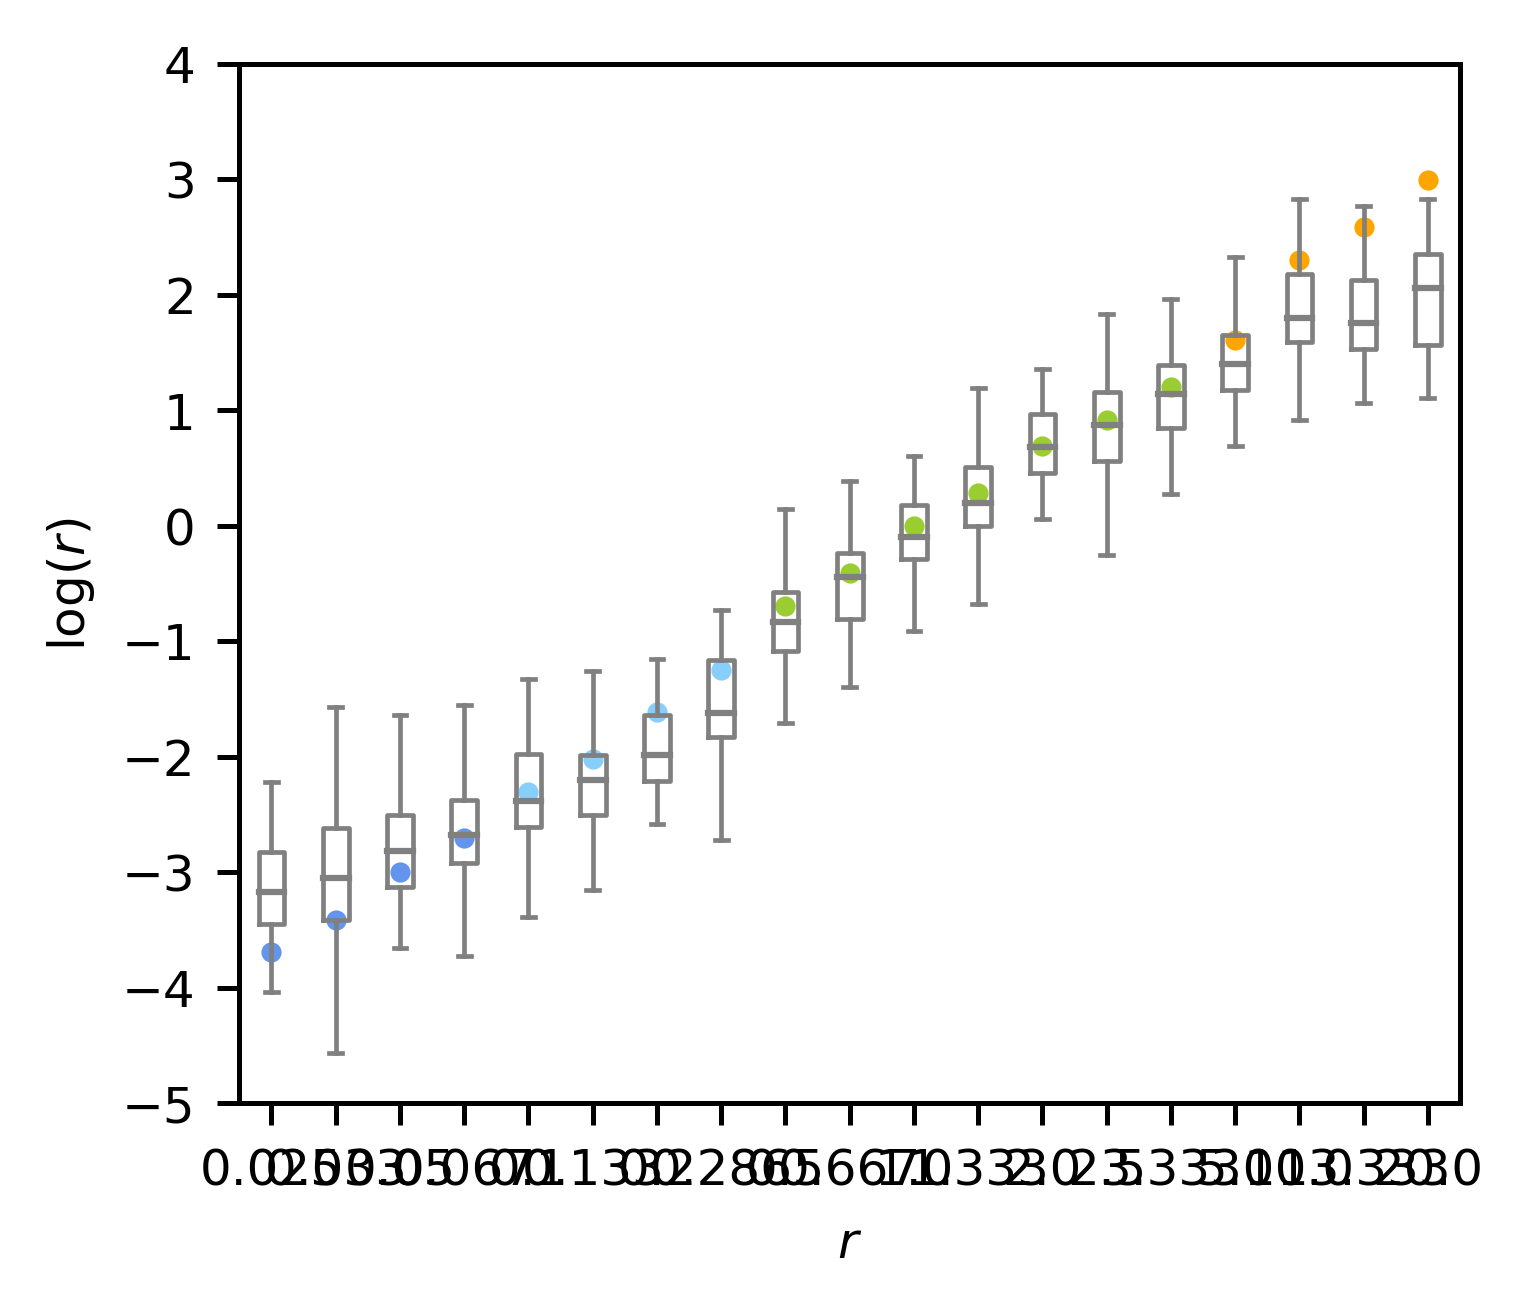

In [33]:
fig, ax = plt.subplots(figsize=(3.5,3),dpi=450)
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}
line_properties = dict(linestyle='-', linewidth=0.75, color='gray')
for r_idx in range(19):
    r = rs[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    # Plot each boxplot at position k_idx + 1
#     y = np.exp()
#     ax.boxplot(results[k], positions=[k_idx + 1])
    ax.boxplot(results[r], positions=[r_idx + 1],showfliers=False,
               boxprops = dict(linestyle='-', linewidth=0.75, color='gray'),
               whiskerprops=line_properties, widths=0.4,
           capprops=line_properties,
              medianprops=dict(linestyle='-', linewidth=1, color='gray'))
    
    myc = colors[c]
    # Plot the scatter point at the same position
    ax.scatter(r_idx + 1, k, color=myc, s=5)

    print(len(results[r]))

# Show the plot after adding all boxplots
ax.set_xticks(range(1, 20))  # Setting x-ticks positions
ax.set_xticklabels(rs)  # Assuming 'rs' is your array of labels
plt.ylim(-5,4)
plt.xlabel('$r$',size=8)
plt.ylabel('$\log(r)$',size=8)
ax.tick_params(axis='both', labelsize=8)
# plt.show()
# plt.savefig("gnn_regression.pdf", bbox_inches='tight', pad_inches=0)

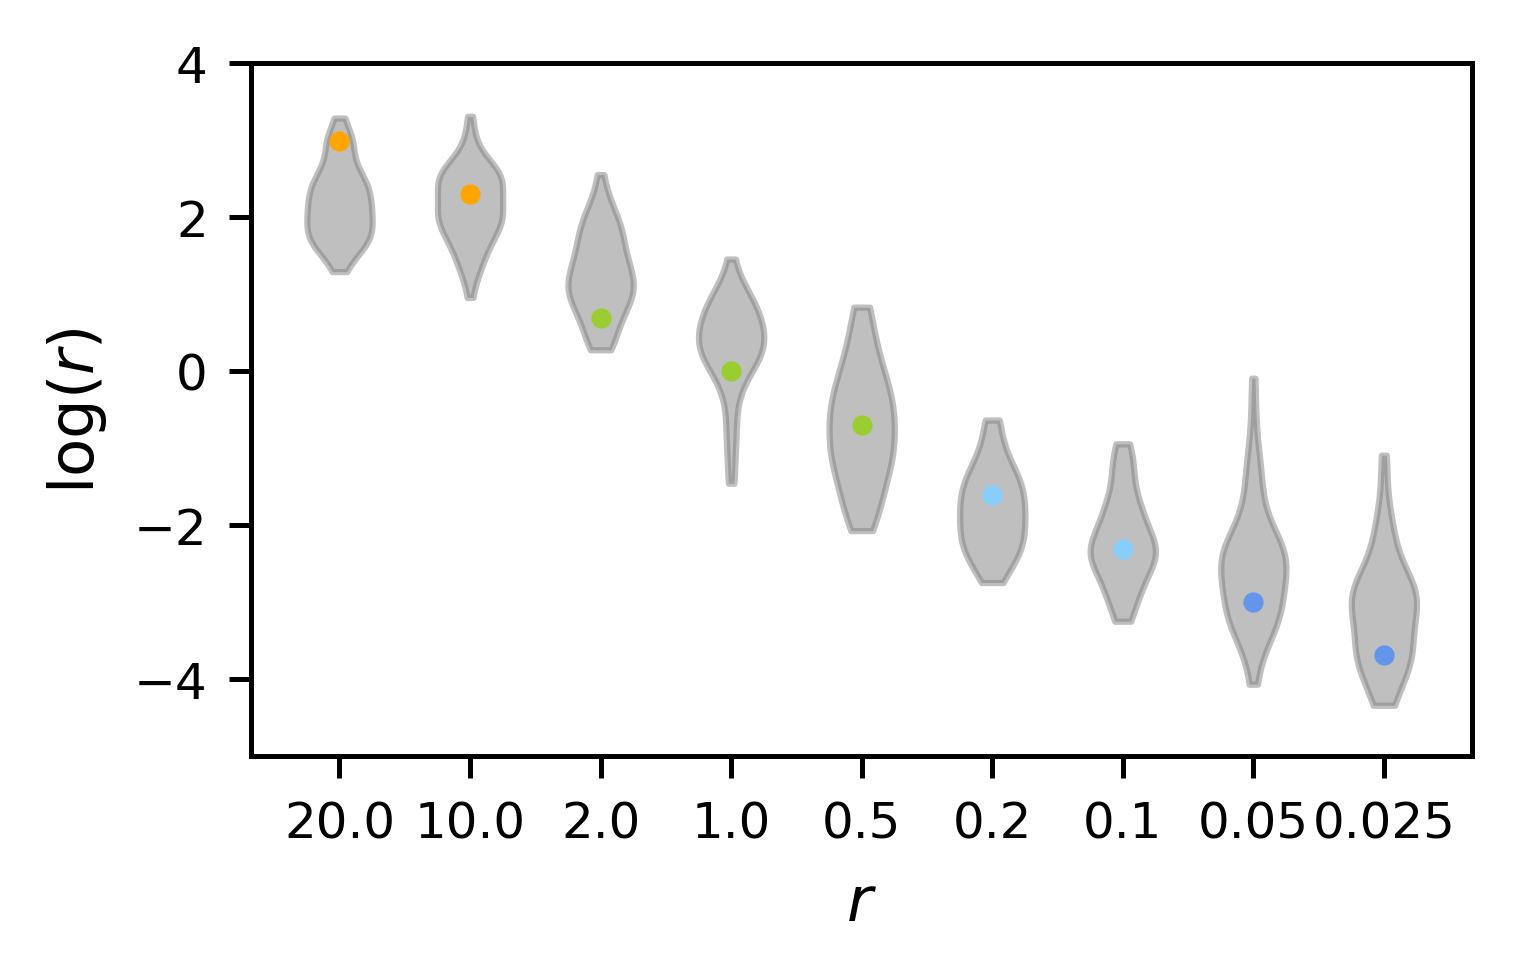

In [160]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'results' and 'rs' are defined as before

fig, ax = plt.subplots(figsize=(3.5,2), dpi=450)

colors = {0:'orange', 1:'yellowgreen', 2:'lightskyblue', 3:'cornflowerblue'}
r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}

for r_idx in range(9):
    r = rs[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    
    # Creating the violin plot at position r_idx + 1
    vp = ax.violinplot(results[r], positions=[r_idx + 1], showmeans=False, showmedians=False, showextrema=False)
    
    # You can set the color of each part of the violin plot
    for pc in vp['bodies']:
        pc.set_facecolor('grey')
        pc.set_edgecolor('grey')
        pc.set_alpha(0.5)

    # Plot the scatter point at the same position
    ax.scatter(r_idx + 1, k, color=colors[c], s=5)

# Setting x-ticks positions and labels
ax.set_xticks(range(1, 10))
ax.set_xticklabels(rs)

# Setting the limits for y-axis and font size for ticks
plt.ylim(-5, 4)
plt.xlabel('$r$')
plt.ylabel('$\log(r)$')
ax.tick_params(axis='both', labelsize=8)

plt.show()
